# Bright SNe lightcurves

Grab some bright supernovae and plot them.  
Demo of:
* /query/
* /lightcurves/

### Python (3 only) requirements - pip install
lasair, matplotlib, pandas, numpy 


In [1]:
endpoint = "https://lasair-ztf.lsst.ac.uk/api"

In [2]:
import sys, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Grab my Lasair API token
Get your Lasair token before you start. You can log into [Lasair](https://lasair.lsst.ac.uk) and click "My Profile"
at top right. Or use the command-line below.
```bash
curl --data "username=myusername&password=***********" https://lasair-ztf.lsst.ac.uk/api/auth-token/
```
Make a file called settings.py with a line like: `API_TOKEN = '0123456789abcdefxxxxxxxxxxxxxxxxxxxxxxxx'`

In [3]:
from lasair import LasairError, lasair_client as lasair
import settings

L = lasair(settings.API_TOKEN, endpoint=endpoint)

In [4]:
# Just join the objects table and the sherlock_classifications table, just
# pulling out the objectId.
rows = L.query(
    "objects.objectId",
    'objects, sherlock_classifications',
    """ sherlock_classifications.classification = "SN"
        AND objects.gmag < 19 AND objects.rmag < 19
        AND objects.ncandgp > 12 
    """,
    limit=10)
objectIds = [row['objectId'] for row in rows]
print(objectIds)

['ZTF18aaaehwv', 'ZTF18abcvtgy', 'ZTF18abkhgfg', 'ZTF18abrbaow', 'ZTF18abrwrxh', 'ZTF18abxoqkd', 'ZTF18actxlqb', 'ZTF19aanvlpy', 'ZTF19aavqoop', 'ZTF19aavqoyu']


In [6]:
def plot_lc(objectId, candidates):
    # Current Julian Date. Calculated using [INSERT REF FOR FORMULA]
    jd_now = time.time()/86400 + 40587.0 + 2400000.5
    color = {1:'green', 2:'red'}
    for fid in [1,2]:
        since = []
        magpsf = []
        sigmapsf = []
        for cand in candidates:
            if cand['fid'] == fid:
                since.append(cand['jd'] - jd_now)
                magpsf.append(cand['magpsf'])
                sigmapsf.append(cand['sigmapsf'])
        plt.errorbar(since, magpsf, yerr=sigmapsf, c=color[fid])
        plt.xlabel("days before %.2f" % jd_now)
        plt.ylabel("psf mag")
        plt.title('https://lasair-ztf.lsst.ac.uk/objects/%s' % objectId)
    plt.gca().invert_yaxis()
    plt.show()

### Get the Lightcurves and exploring the format

We can retrieve multiple lightcurves at once with the `lasair` object. 

In [30]:
lcs = L.lightcurves(objectIds)

They are returned in a list of JSON files, **let's plot the first one slowly before makign a function**

If we print the first element of our list we can see the `objectId` at the top, the identifier of our transient, followed by a dictionary of `candidates`, which are "candidate detections", each with the following entries:
* `candid`: A Unique identifier for this datapoint [ROY CHECK]
* `jd`: Julan Date
* `ra`: Right Ascension
* `dec`: Declination
* `fid`: Filter ID (1: green , 2: red) [ROY ANYTHING ELSE OR MAYBE LINK TO A WEBPAGE?]
* `nid`: [ROY?],
* `magpsf`: Magnitude
* `sigmapsf`: Error on the mag
* `magnr`: Limiting Maqgnitude [ROY CHECK]
* `sigmagnr`: Error
* `magzpsci`: [ROY HELP]
* `isdiffpos`:[ROY HELP]
* `ssdistnr`: [ROY HELP]
* `ssnamenr`: [ROY HELP]
* `drb`: [ROY HELP]

If the data point is magnitude limit (a **non detection**) the columns are:
* `jd`
* `fid`
* `diffmaglim`: the difference imaging magnitude limit

In [41]:
lcs[0]

{'objectId': 'ZTF18aaaehwv',
 'candidates': [{'candid': 1354493622015015010,
   'jd': 2459108.9936227,
   'ra': 90.5979923,
   'dec': 40.2006177,
   'fid': 2,
   'nid': 1354,
   'magpsf': 18.048900604248047,
   'sigmapsf': 0.06770399957895279,
   'magnr': 22.259000778198242,
   'sigmagnr': 0.13600000739097595,
   'magzpsci': 26.039899826049805,
   'isdiffpos': 't',
   'ssdistnr': -999.0,
   'ssnamenr': 'null',
   'drb': 0.9997490048408508},
  {'candid': 1354519742015015001,
   'jd': 2459109.0197454,
   'ra': 90.5980306,
   'dec': 40.200635,
   'fid': 1,
   'nid': 1354,
   'magpsf': 18.03230094909668,
   'sigmapsf': 0.0804620012640953,
   'magnr': 22.7450008392334,
   'sigmagnr': 0.2280000001192093,
   'magzpsci': 25.920299530029297,
   'isdiffpos': 't',
   'ssdistnr': -999.0,
   'ssnamenr': 'null',
   'drb': 0.9999499917030334},
  {'candid': 1354524502015015004,
   'jd': 2459109.0245023,
   'ra': 90.5980584,
   'dec': 40.2006473,
   'fid': 1,
   'nid': 1354,
   'magpsf': 17.97459983825

Let's reformat the data to make it easier to plot

In [46]:
# first we can save our object's name to a variable 
objectId = lcs[0]['objectId']
# Then we can use pandas DataFrames to neatly format our lightcurve
df = pd.DataFrame(lcs[0]['candidates']) 

In [47]:
df

,candid,jd,ra,dec,fid,nid,magpsf,sigmapsf,magnr,sigmagnr,magzpsci,isdiffpos,ssdistnr,ssnamenr,drb,diffmaglim
0,1.354494e+18,2.459109e+06,90.597992,40.200618,2,1354.0,18.048901,0.067704,22.259001,0.136,26.039900,t,-999.0,null,0.999749,NaN
1,1.354520e+18,2.459109e+06,90.598031,40.200635,1,1354.0,18.032301,0.080462,22.745001,0.228,25.920300,t,-999.0,null,0.999950,NaN
2,1.354525e+18,2.459109e+06,90.598058,40.200647,1,1354.0,17.974600,0.076123,22.745001,0.228,25.912600,t,-999.0,null,0.999986,NaN
3,1.355527e+18,2.459110e+06,90.598039,40.200584,2,1355.0,18.108700,0.073527,22.259001,0.136,26.122700,t,-999.0,null,0.999994,NaN
4,1.357389e+18,2.459112e+06,90.597947,40.200638,1,1357.0,18.690001,0.079755,22.745001,0.228,25.951000,t,-999.0,null,1.000000,NaN
5,1.357502e+18,2.459112e+06,90.598006,40.200619,2,1357.0,18.390600,0.054964,22.259001,0.136,26.249599,t,-999.0,null,1.000000,NaN
6,1.358497e+18,2.459113e+06,90.598019,40.200626,2,1358.0,18.547600,0.094704,22.259001,0.136,26.291599,t,-999.0,null,0.999781,NaN
7,1.360491e+18,2.459115e+06,90.597995,40.200609,2,1360.0,18.983299,0.097809,22.259001,0.136,26.241301,t,-999.0,null,0.999988,NaN
8,1.360500e+18,2.459115e+06,90.598008,40.200630,2,1360.0,19.027700,0.091110,22.259001,0.136,26.255699,t,-999.0,null,0.999891,NaN
9,1.360512e+18,2.459115e+06,90.597943,40.200614,1,1360.0,19.269300,0.120214,22.745001,0.228,26.233299,t,-999.0,null,0.999998,NaN


### Plotting

When ploting our lightcurve it's useful to plot with respect to a specific date (i.e. a phase) - here we calculate our phase with respect to the current julian date.

In [32]:
 # Current Julian Date. Calculated using [INSERT REF FOR FORMULA]
jd_now = time.time()/86400 + 40587.0 + 2400000.5

In [49]:
# let's add a column to our dataframe
df['phase'] = df.jd.values - jd_now

In [50]:
df

,candid,jd,ra,dec,fid,nid,magpsf,sigmapsf,magnr,sigmagnr,magzpsci,isdiffpos,ssdistnr,ssnamenr,drb,diffmaglim,phase
0,1.354494e+18,2.459109e+06,90.597992,40.200618,2,1354.0,18.048901,0.067704,22.259001,0.136,26.039900,t,-999.0,null,0.999749,NaN,-1575.172855
1,1.354520e+18,2.459109e+06,90.598031,40.200635,1,1354.0,18.032301,0.080462,22.745001,0.228,25.920300,t,-999.0,null,0.999950,NaN,-1575.146732
2,1.354525e+18,2.459109e+06,90.598058,40.200647,1,1354.0,17.974600,0.076123,22.745001,0.228,25.912600,t,-999.0,null,0.999986,NaN,-1575.141976
3,1.355527e+18,2.459110e+06,90.598039,40.200584,2,1355.0,18.108700,0.073527,22.259001,0.136,26.122700,t,-999.0,null,0.999994,NaN,-1574.139337
4,1.357389e+18,2.459112e+06,90.597947,40.200638,1,1357.0,18.690001,0.079755,22.745001,0.228,25.951000,t,-999.0,null,1.000000,NaN,-1572.277554
5,1.357502e+18,2.459112e+06,90.598006,40.200619,2,1357.0,18.390600,0.054964,22.259001,0.136,26.249599,t,-999.0,null,1.000000,NaN,-1572.164476
6,1.358497e+18,2.459113e+06,90.598019,40.200626,2,1358.0,18.547600,0.094704,22.259001,0.136,26.291599,t,-999.0,null,0.999781,NaN,-1571.169383
7,1.360491e+18,2.459115e+06,90.597995,40.200609,2,1360.0,18.983299,0.097809,22.259001,0.136,26.241301,t,-999.0,null,0.999988,NaN,-1569.175598
8,1.360500e+18,2.459115e+06,90.598008,40.200630,2,1360.0,19.027700,0.091110,22.259001,0.136,26.255699,t,-999.0,null,0.999891,NaN,-1569.166547
9,1.360512e+18,2.459115e+06,90.597943,40.200614,1,1360.0,19.269300,0.120214,22.745001,0.228,26.233299,t,-999.0,null,0.999998,NaN,-1569.154441


Now let's plot!

Text(0, 0.5, 'psf mag')

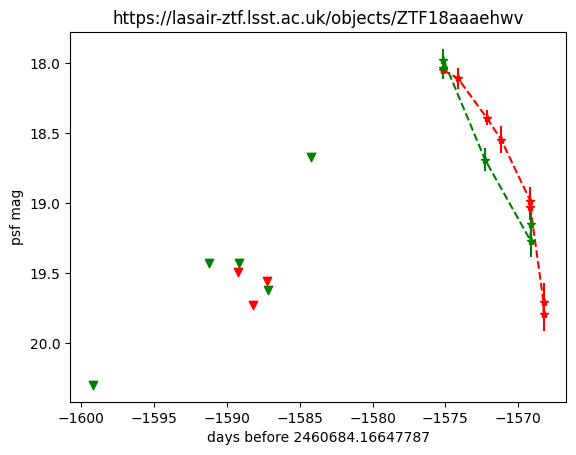

In [56]:
_red_det_mask = (df.fid==2) & ~df.candid.isna()
_red_nondet_mask = (df.fid==2) & df.candid.isna()
_green_det_mask = (df.fid==1) & ~df.candid.isna()
_green_nondet_mask = (df.fid==1) & df.candid.isna()

# Plot the detections
plt.errorbar(df['phase'].values[_red_det_mask], 
             df['magpsf'].values[_red_det_mask],
             yerr = df['sigmapsf'].values[_red_det_mask],
             color = 'red', 
             marker='*',
             ls = '--'
            )

plt.errorbar(df['phase'].values[_green_det_mask], 
             df['magpsf'].values[_green_det_mask],
             yerr = df['sigmapsf'].values[_green_det_mask],
             color = 'green', 
             marker='*',
             ls = '--'
            )

# Plot the non detections
plt.scatter(df['phase'].values[_red_nondet_mask], 
             df['diffmaglim'].values[_red_nondet_mask],
             color = 'red', 
             marker='v'
            )

plt.scatter(df['phase'].values[_green_nondet_mask], 
             df['diffmaglim'].values[_green_nondet_mask],
             color = 'green', 
             marker='v'
            )

plt.title(f'https://lasair-ztf.lsst.ac.uk/objects/{objectId}')

plt.gca().invert_yaxis()
plt.xlabel(f"days before {jd_now}")
plt.ylabel("psf mag")

## Let's do our plotting in a loop:


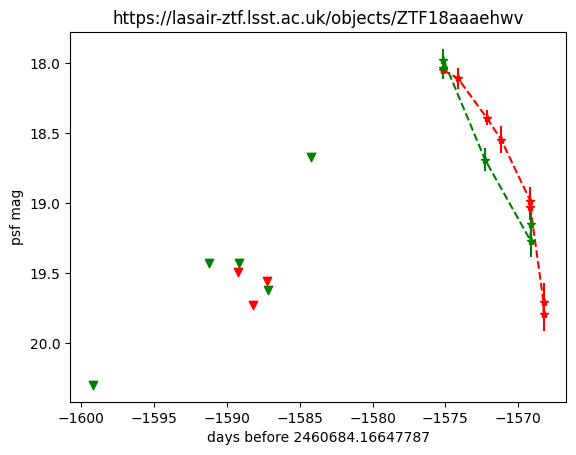

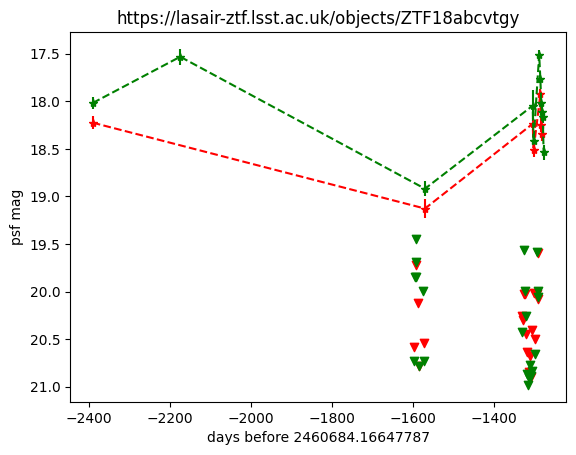

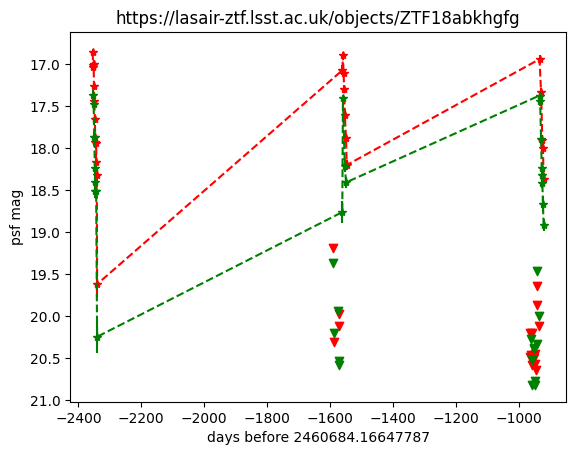

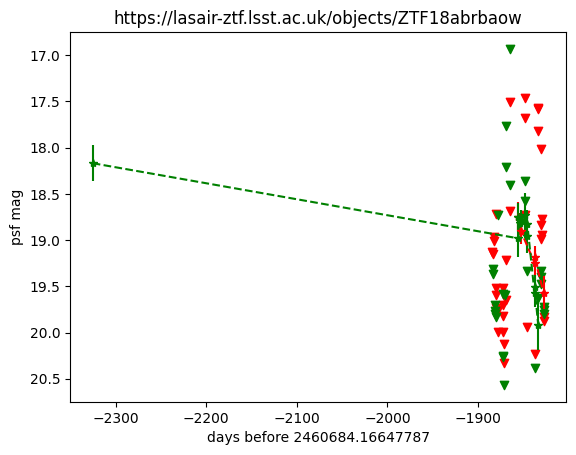

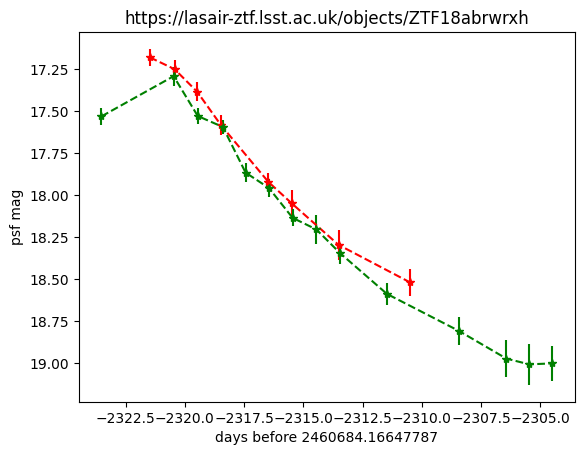

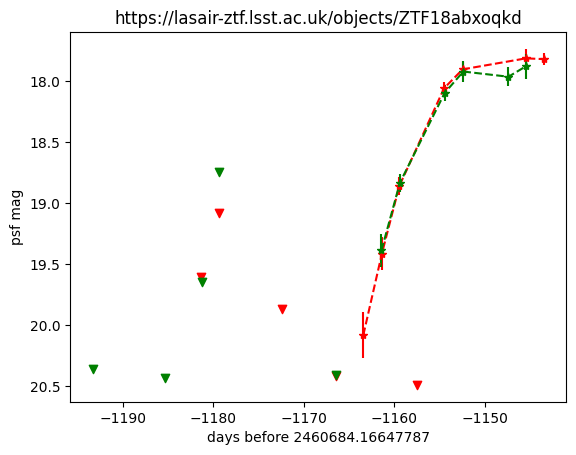

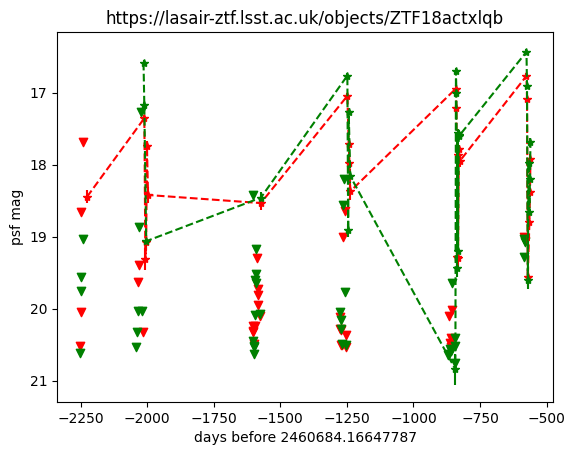

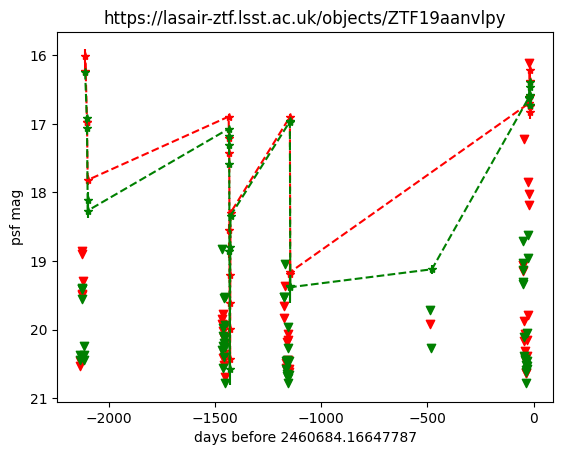

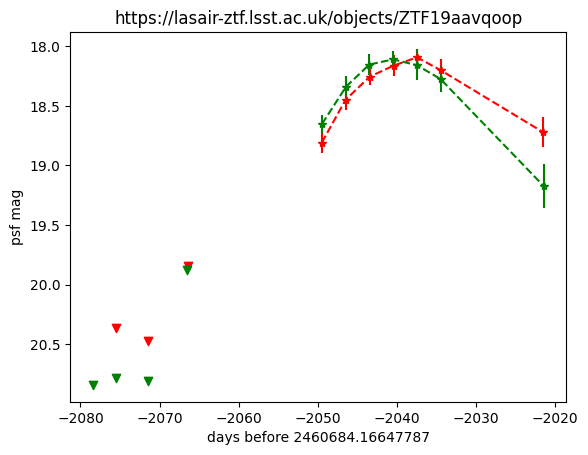

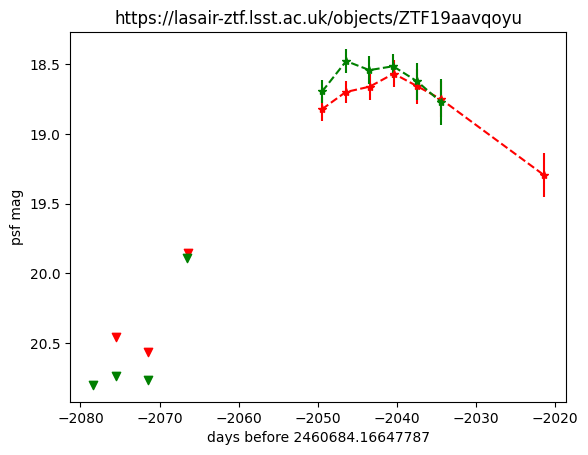

In [58]:
for i in range(len(lcs)):
    # first we can save our object's name to a variable 
    objectId = lcs[i]['objectId']
    # Then we can use pandas DataFrames to neatly format our lightcurve
    df = pd.DataFrame(lcs[i]['candidates']) 
    # let's add a column to our dataframe
    df['phase'] = df.jd.values - jd_now
    
    _red_det_mask = (df.fid==2) & ~df.candid.isna()
    _red_nondet_mask = (df.fid==2) & df.candid.isna()
    _green_det_mask = (df.fid==1) & ~df.candid.isna()
    _green_nondet_mask = (df.fid==1) & df.candid.isna()

    # Plot the detections
    plt.errorbar(df['phase'].values[_red_det_mask], 
                 df['magpsf'].values[_red_det_mask],
                 yerr = df['sigmapsf'].values[_red_det_mask],
                 color = 'red', 
                 marker='*',
                 ls = '--'
                )

    plt.errorbar(df['phase'].values[_green_det_mask], 
                 df['magpsf'].values[_green_det_mask],
                 yerr = df['sigmapsf'].values[_green_det_mask],
                 color = 'green', 
                 marker='*',
                 ls = '--'
                )

    try:
        # Plot the non detections
        plt.scatter(df['phase'].values[_red_nondet_mask], 
                     df['diffmaglim'].values[_red_nondet_mask],
                     color = 'red', 
                     marker='v'
                    )

        plt.scatter(df['phase'].values[_green_nondet_mask], 
                     df['diffmaglim'].values[_green_nondet_mask],
                     color = 'green', 
                     marker='v'
                    )
    # this happens when the LC only has detections and there are no non-dets
    except KeyError:
        pass 
    
    plt.title(f'https://lasair-ztf.lsst.ac.uk/objects/{objectId}')

    plt.gca().invert_yaxis()
    plt.xlabel(f"days before {jd_now}")
    plt.ylabel("psf mag")
    plt.show()

## Plotting only the detections

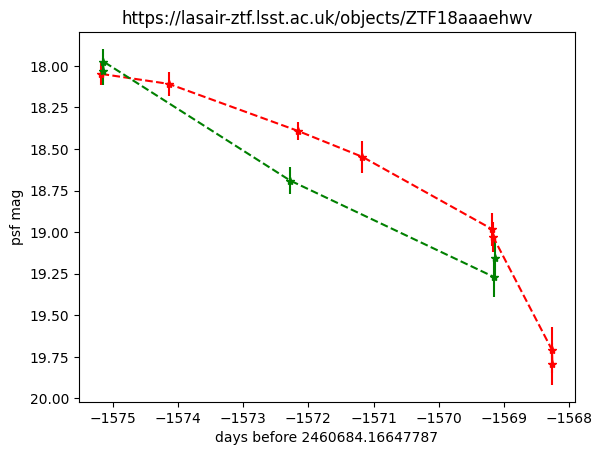

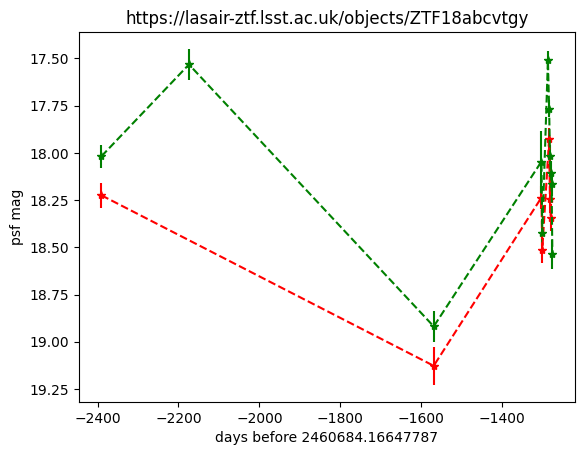

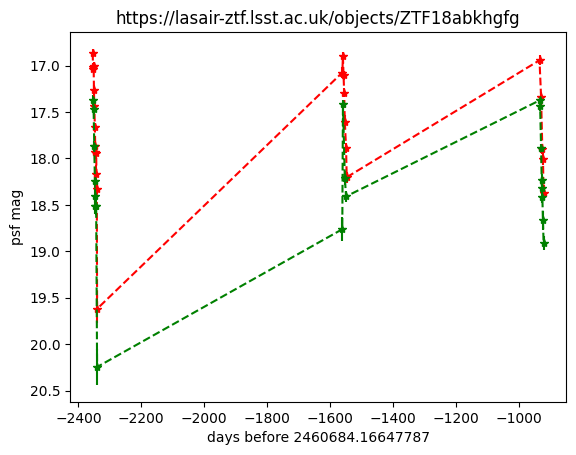

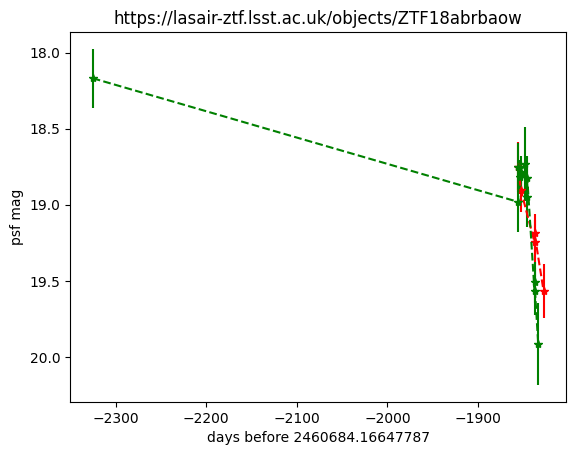

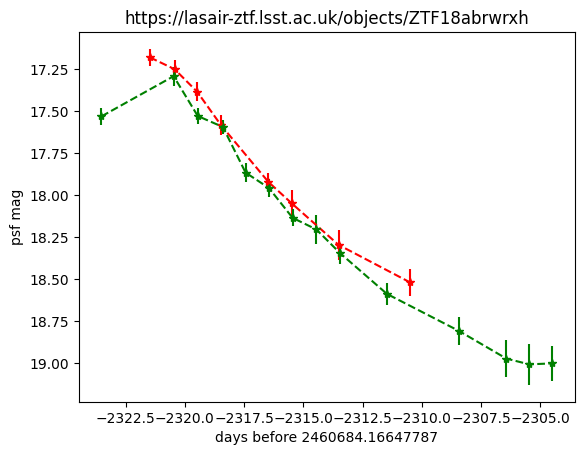

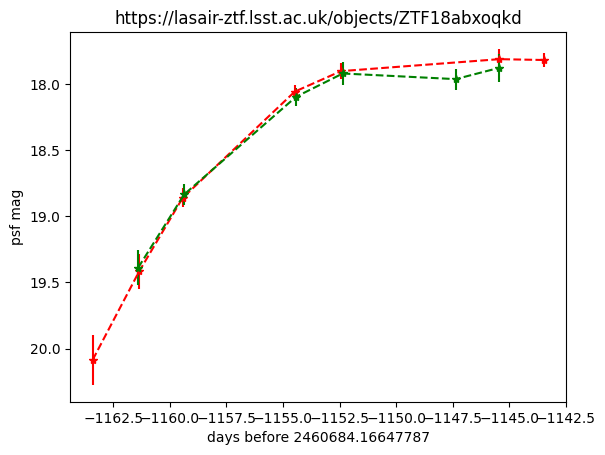

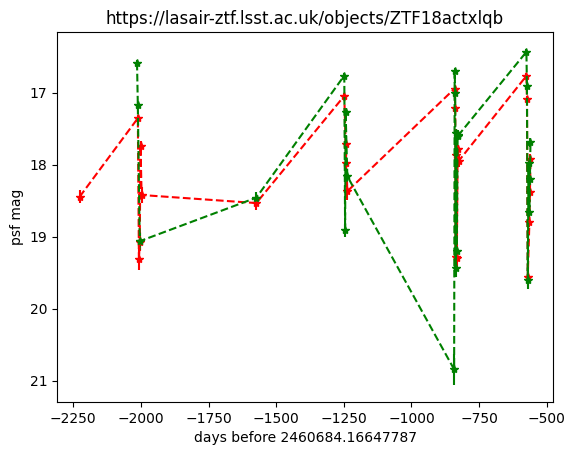

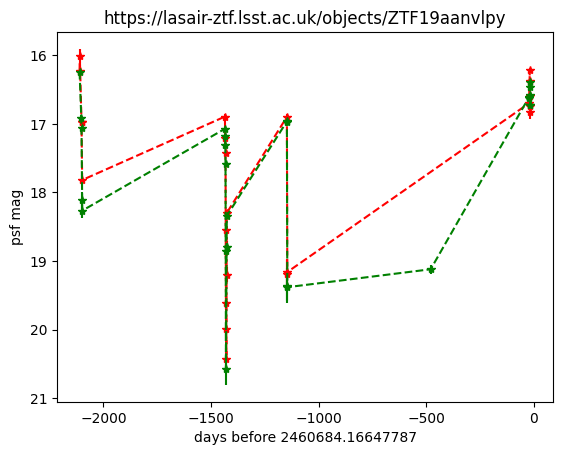

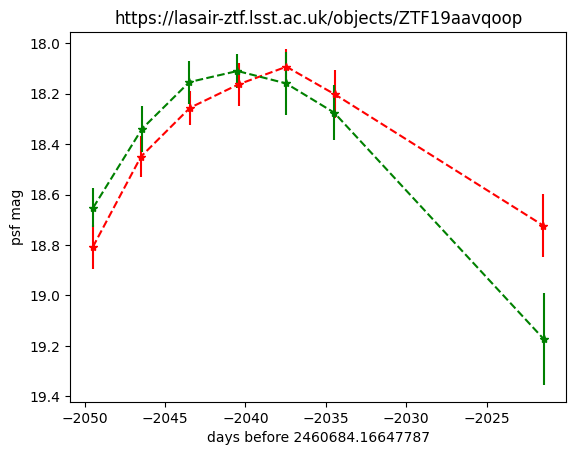

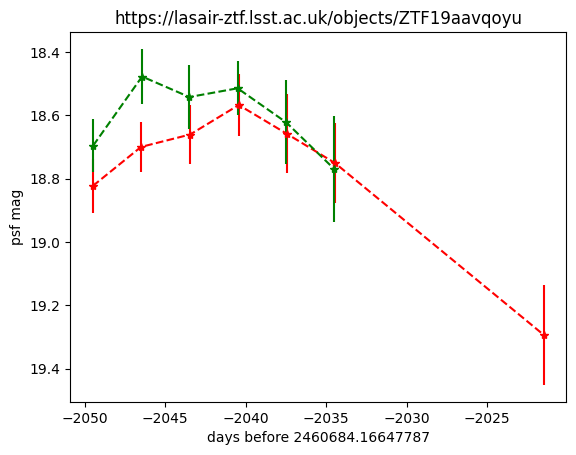

In [59]:
for i in range(len(lcs)):
    # first we can save our object's name to a variable 
    objectId = lcs[i]['objectId']
    # Then we can use pandas DataFrames to neatly format our lightcurve
    df = pd.DataFrame(lcs[i]['candidates']) 
    # let's add a column to our dataframe
    df['phase'] = df.jd.values - jd_now
    
    _red_det_mask = (df.fid==2) & ~df.candid.isna()
    _red_nondet_mask = (df.fid==2) & df.candid.isna()
    _green_det_mask = (df.fid==1) & ~df.candid.isna()
    _green_nondet_mask = (df.fid==1) & df.candid.isna()

    # Plot the detections
    plt.errorbar(df['phase'].values[_red_det_mask], 
                 df['magpsf'].values[_red_det_mask],
                 yerr = df['sigmapsf'].values[_red_det_mask],
                 color = 'red', 
                 marker='*',
                 ls = '--'
                )

    plt.errorbar(df['phase'].values[_green_det_mask], 
                 df['magpsf'].values[_green_det_mask],
                 yerr = df['sigmapsf'].values[_green_det_mask],
                 color = 'green', 
                 marker='*',
                 ls = '--'
                )
    
    plt.title(f'https://lasair-ztf.lsst.ac.uk/objects/{objectId}')

    plt.gca().invert_yaxis()
    plt.xlabel(f"days before {jd_now}")
    plt.ylabel("psf mag")
    plt.show()